In [8]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader, random_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# Configuration / Hyperparameters
# Configuration / Hyperparameters
CONFIG = {
    "input_csv_path": r"E:\Projects\meghProject\18Channels.csv",
    "num_channels": 19,
    "features_per_channel": 7,
    "lstm_hidden_size": 128,  # Increased from 64
    "num_lstm_layers": 2,
    "attention_dim": 64,  # Increased from 32
    "fc_hidden_dim": 256,  # Increased from 128
    "dropout_rate": 0.3,  # Slightly reduced from 0.4
    "learning_rate": 1e-3,  # Initial learning rate
    "weight_decay": 1e-5,  # Added L2 regularization
    "batch_size": 32,
    "num_epochs": 100,  # Kept at 100, early stopping and LR scheduler will manage
    "test_size": 0.2,
    "val_size": 0.15,
    "random_seed": 42,
    "device": torch.device("cuda" if torch.cuda.is_available() else "cpu"),
}

# Set random seeds for reproducibility
torch.manual_seed(CONFIG["random_seed"])
np.random.seed(CONFIG["random_seed"])
if CONFIG["device"].type == "cuda":
    torch.cuda.manual_seed_all(CONFIG["random_seed"])

# 1. Data Loading and Preprocessing
def load_and_preprocess_data(csv_path, config):
    """
    Loads data from CSV, preprocesses it, and splits into train, validation, and test sets.
    """
    df = pd.read_csv(csv_path)

    # Define channel prefixes and feature suffixes
    channel_prefixes = ["Fp1", "Fp2", "F3", "F4", "C3", "C4", "P3", "P4",
                        "O1", "O2", "F7", "F8", "T3", "T4", "T5", "T6",
                        "Fz", "Cz", "Pz"]
    feature_suffixes = ["LBP", "VAR", "STD", "KUR", "AE", "RMS", "L2"]

    # Extract channel features
    channel_feature_columns = []
    for ch in channel_prefixes:
        for feat in feature_suffixes:
            channel_feature_columns.append(f"{ch}_{feat}")

    X_channel_data = df[channel_feature_columns].values

    # Reshape channel data: (num_samples, num_channels, features_per_channel)
    X_channel_data = X_channel_data.reshape(-1, config["num_channels"], config["features_per_channel"])

    # Extract demographic features
    X_age = df['age'].values.reshape(-1, 1)

    # Encode 'sex'
    sex_encoder = LabelEncoder()
    X_sex_encoded = sex_encoder.fit_transform(df['sex']).reshape(-1, 1)
    # If you want one-hot encoding for sex (often better for NNs):
    X_sex_one_hot = pd.get_dummies(df["sex"], prefix="sex", dtype=float).values
    # This will create columns like sex_F, sex_M.
    # The number of columns will be the number of unique sex categories.

    # Extract labels (already there)
    # y = df['label'].values

    # Modify train_test_split to include X_sex_one_hot
    (
        X_channel_train_val,
        X_channel_test,
        X_age_train_val,
        X_age_test,
        X_sex_train_val,
        X_sex_test,
        y_train_val,
        y_test,
    ) = train_test_split(
        X_channel_data,
        X_age,
        X_sex_one_hot,
        y,  # Use X_sex_one_hot here
        test_size=config["test_size"],
        random_state=config["random_seed"],
        stratify=y,
    )

    # Adjust the subsequent train_test_split for validation set accordingly
    (
        X_channel_train,
        X_channel_val,
        X_age_train,
        X_age_val,
        X_sex_train,
        X_sex_val,
        y_train,
        y_val,
    ) = train_test_split(
        X_channel_train_val,
        X_age_train_val,
        X_sex_train_val,
        y_train_val,  # X_sex_train_val is now one-hot
        test_size=config["val_size"] / (1 - config["test_size"]),
        random_state=config["random_seed"],
        stratify=y_train_val,
    )

    # Split train+val into train and val
    # (val_size is proportion of original train_val set)
    X_channel_train, X_channel_val, \
    X_age_train, X_age_val, \
    X_sex_train, X_sex_val, \
    y_train, y_val = train_test_split(
        X_channel_train_val, X_age_train_val, X_sex_train_val, y_train_val,
        test_size=config["val_size"] / (1-config["test_size"]), # Adjust val_size proportion
        random_state=config["random_seed"], stratify=y_train_val
    )

    # --- Scaling ---
    # Scale channel features (fit on training data only)
    # Reshape to 2D for scaler, then reshape back
    scaler_channel = StandardScaler()
    n_samples_train, n_channels, n_features_ch = X_channel_train.shape
    X_channel_train_flat = X_channel_train.reshape(n_samples_train, -1)
    scaler_channel.fit(X_channel_train_flat)

    X_channel_train = scaler_channel.transform(X_channel_train_flat).reshape(n_samples_train, n_channels, n_features_ch)

    n_samples_val = X_channel_val.shape[0]
    X_channel_val = scaler_channel.transform(X_channel_val.reshape(n_samples_val, -1)).reshape(n_samples_val, n_channels, n_features_ch)

    n_samples_test = X_channel_test.shape[0]
    X_channel_test = scaler_channel.transform(X_channel_test.reshape(n_samples_test, -1)).reshape(n_samples_test, n_channels, n_features_ch)

    # Scale age (fit on training data only)
    scaler_age = StandardScaler()
    X_age_train = scaler_age.fit_transform(X_age_train)
    X_age_val = scaler_age.transform(X_age_val)
    X_age_test = scaler_age.transform(X_age_test)

    # Convert to PyTorch tensors
    X_channel_train_t = torch.tensor(X_channel_train, dtype=torch.float32)
    X_age_train_t = torch.tensor(X_age_train, dtype=torch.float32)
    X_sex_train_t = torch.tensor(
        X_sex_train, dtype=torch.float32
    )  # This is now one-hot encoded
    y_train_t = torch.tensor(y_train, dtype=torch.float32).unsqueeze(1)

    X_channel_val_t = torch.tensor(X_channel_val, dtype=torch.float32)
    X_age_val_t = torch.tensor(X_age_val, dtype=torch.float32)
    X_sex_val_t = torch.tensor(
        X_sex_val, dtype=torch.float32
    )  # This is now one-hot encoded
    y_val_t = torch.tensor(y_val, dtype=torch.float32).unsqueeze(1)

    X_channel_test_t = torch.tensor(X_channel_test, dtype=torch.float32)
    X_age_test_t = torch.tensor(X_age_test, dtype=torch.float32)
    X_sex_test_t = torch.tensor(
        X_sex_test, dtype=torch.float32
    )  # This is now one-hot encoded
    y_test_t = torch.tensor(y_test, dtype=torch.float32).unsqueeze(1)

    # Create TensorDatasets (remains the same)
    # Create DataLoaders (remains the same)
    # print statement (remains the same)

    # Return the number of one-hot encoded sex features instead of sex_encoder.classes_
    num_sex_features = X_sex_train_t.shape[1]
    return train_loader, val_loader, test_loader, num_sex_features

# 2. Model Definition
class Attention(nn.Module):
    """ Simple Additive Attention mechanism """
    def __init__(self, hidden_dim, attention_dim):
        super(Attention, self).__init__()
        self.W_q = nn.Linear(hidden_dim, attention_dim, bias=False)
        self.W_k = nn.Linear(hidden_dim, attention_dim, bias=False)
        self.V = nn.Linear(attention_dim, 1, bias=False)
        self.tanh = nn.Tanh()
        self.softmax = nn.Softmax(dim=1)

    def forward(self, lstm_output):
        # lstm_output: (batch_size, seq_len, hidden_dim)

        # Project query and key. For self-attention on LSTM outputs, query and key are the same.
        q = self.W_q(lstm_output) # (batch_size, seq_len, attention_dim)
        k = self.W_k(lstm_output) # (batch_size, seq_len, attention_dim)

        # Calculate attention scores
        # Simple additive attention: V * tanh(W_q*q + W_k*k)
        # Here, we'll use a common variant: V * tanh(W*h_i)
        # For simplicity let's use: V * tanh(W_k * lstm_output)
        # A more typical additive/Bahdanau style would be V * tanh( W_q * query + W_k * keys )
        # For self-attention, it's common to project, then compute dot products or use an MLP.
        # Let's use a simplified approach inspired by Bahdanau for self-attention:

        # Project LSTM outputs
        projected_h = self.tanh(self.W_k(lstm_output)) # (batch_size, seq_len, attention_dim)

        # Compute scores
        scores = self.V(projected_h)  # (batch_size, seq_len, 1)
        scores = scores.squeeze(2)    # (batch_size, seq_len)

        # Get attention weights
        attention_weights = self.softmax(scores) # (batch_size, seq_len)

        # Apply attention weights to LSTM outputs
        # context_vector shape: (batch_size, seq_len, hidden_dim) * (batch_size, seq_len, 1) -> sum over seq_len
        context_vector = torch.bmm(attention_weights.unsqueeze(1), lstm_output)
        # context_vector shape: (batch_size, 1, hidden_dim)
        context_vector = context_vector.squeeze(1) # (batch_size, hidden_dim)

        return context_vector, attention_weights


class BiLSTMWithAttention(nn.Module):
    def __init__(
        self,
        input_dim,
        lstm_hidden_dim,
        num_lstm_layers,
        attention_dim,
        fc_hidden_dim,
        output_dim,
        dropout_rate,
        num_demographic_features,
    ):  # num_demographic_features will now include one-hot sex
        super(BiLSTMWithAttention, self).__init__()

        self.lstm = nn.LSTM(
            input_size=input_dim,
            hidden_size=lstm_hidden_dim,
            num_layers=num_lstm_layers,
            batch_first=True,
            bidirectional=True,
            dropout=dropout_rate if num_lstm_layers > 1 else 0,
        )

        # Add Layer Normalization after LSTM
        # The input to LayerNorm will be (batch, seq_len, lstm_hidden_dim * 2)
        # We normalize over the last dimension (features)
        self.layer_norm = nn.LayerNorm(lstm_hidden_dim * 2)

        self.attention = Attention(lstm_hidden_dim * 2, attention_dim)

        self.fc1 = nn.Linear(
            lstm_hidden_dim * 2 + num_demographic_features, fc_hidden_dim
        )
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(dropout_rate)
        # Optional: Add another FC layer for more capacity in the classifier
        # self.fc_intermediate = nn.Linear(fc_hidden_dim, fc_hidden_dim // 2)
        # self.relu2 = nn.ReLU()
        # self.dropout2 = nn.Dropout(dropout_rate)
        # self.fc2 = nn.Linear(fc_hidden_dim // 2, output_dim)
        self.fc2 = nn.Linear(fc_hidden_dim, output_dim)

    def forward(self, x_channel, x_age, x_sex):
        lstm_out, _ = self.lstm(x_channel)

        # Apply Layer Normalization
        lstm_out_norm = self.layer_norm(lstm_out)

        attention_context, attention_weights = self.attention(
            lstm_out_norm
        )  # Use normalized output for attention

        combined_features = torch.cat((attention_context, x_age, x_sex), dim=1)

        out = self.fc1(combined_features)
        out = self.relu(out)
        out = self.dropout(out)
        # if using intermediate layer:
        # out = self.fc_intermediate(out)
        # out = self.relu2(out)
        # out = self.dropout2(out)
        out = self.fc2(out)

        return out, attention_weights

    def forward(self, x_channel, x_age, x_sex):
        # x_channel: (batch_size, num_channels/seq_len, features_per_channel)
        # x_age: (batch_size, 1)
        # x_sex: (batch_size, 1) or (batch_size, num_sex_categories if one-hot)

        # BiLSTM part
        lstm_out, _ = self.lstm(x_channel)
        # lstm_out: (batch_size, seq_len, lstm_hidden_dim * 2)

        # Attention part
        attention_context, attention_weights = self.attention(lstm_out)
        # attention_context: (batch_size, lstm_hidden_dim * 2)

        # Concatenate attention context with demographic features
        combined_features = torch.cat((attention_context, x_age, x_sex), dim=1)

        # Classifier part
        out = self.fc1(combined_features)
        out = self.relu(out)
        out = self.dropout(out)
        out = self.fc2(out)

        return out, attention_weights # Return attention weights for inspection


# 3. Training and Evaluation Functions
def train_epoch(model, data_loader, criterion, optimizer, device):
    model.train()
    total_loss = 0
    correct_predictions = 0
    total_samples = 0

    for x_ch, x_age, x_sex, y_batch in data_loader:
        x_ch, x_age, x_sex, y_batch = x_ch.to(device), x_age.to(device), x_sex.to(device), y_batch.to(device)

        optimizer.zero_grad()
        outputs, _ = model(x_ch, x_age, x_sex)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()

        total_loss += loss.item() * x_ch.size(0)
        
        preds = torch.sigmoid(outputs) > 0.5
        correct_predictions += (preds == y_batch).sum().item()
        total_samples += y_batch.size(0)

    avg_loss = total_loss / total_samples
    accuracy = correct_predictions / total_samples
    return avg_loss, accuracy

def evaluate_epoch(model, data_loader, criterion, device):
    model.eval()
    total_loss = 0
    correct_predictions = 0
    total_samples = 0
    
    all_attention_weights = []

    with torch.no_grad():
        for x_ch, x_age, x_sex, y_batch in data_loader:
            x_ch, x_age, x_sex, y_batch = x_ch.to(device), x_age.to(device), x_sex.to(device), y_batch.to(device)
            
            outputs, att_weights = model(x_ch, x_age, x_sex)
            loss = criterion(outputs, y_batch)
            
            total_loss += loss.item() * x_ch.size(0)
            preds = torch.sigmoid(outputs) > 0.5
            correct_predictions += (preds == y_batch).sum().item()
            total_samples += y_batch.size(0)
            
            if att_weights is not None: # Store attention weights
                all_attention_weights.append(att_weights.cpu().numpy())


    avg_loss = total_loss / total_samples
    accuracy = correct_predictions / total_samples
    
    if all_attention_weights:
        all_attention_weights = np.concatenate(all_attention_weights, axis=0)
        
    return avg_loss, accuracy, all_attention_weights


# 4. Main Execution
if __name__ == "__main__":
    # Create a dummy CSV file for testing if it doesn't exist
    # In a real scenario, replace "your_eeg_data.csv" with your actual file path
    try:
        pd.read_csv(CONFIG["input_csv_path"])
        print(f"Using existing CSV: {CONFIG['input_csv_path']}")
    except FileNotFoundError:
        print(f"CSV file '{CONFIG['input_csv_path']}' not found. Creating a dummy CSV for demonstration.")
        num_samples_dummy = 100 # Small dummy dataset
        channel_prefixes = ["Fp1", "Fp2", "F3", "F4", "C3", "C4", "P3", "P4",
                            "O1", "O2", "F7", "F8", "T3", "T4", "T5", "T6",
                            "Fz", "Cz", "Pz"]
        feature_suffixes = ["LBP", "VAR", "STD", "KUR", "AE", "RMS", "L2"]
        
        header = []
        for ch in channel_prefixes:
            for feat in feature_suffixes:
                header.append(f"{ch}_{feat}")
        header.extend(["label", "age", "sex"])

        data = np.random.rand(num_samples_dummy, len(header)-3) # -3 for label, age, sex
        labels = np.random.randint(0, 2, num_samples_dummy)
        ages = np.random.randint(18, 70, num_samples_dummy)
        sexes = np.random.choice(['M', 'F'], num_samples_dummy)
        
        dummy_df_data = np.column_stack((data, labels, ages, sexes))
        dummy_df = pd.DataFrame(dummy_df_data, columns=header)
        # Ensure correct types for dummy data
        for col in dummy_df.columns:
            if col not in ["label", "age", "sex"]:
                dummy_df[col] = pd.to_numeric(dummy_df[col], errors='coerce')
        dummy_df["label"] = pd.to_numeric(dummy_df["label"], errors='coerce').astype(int)
        dummy_df["age"] = pd.to_numeric(dummy_df["age"], errors='coerce').astype(int)

        dummy_df.to_csv(CONFIG["input_csv_path"], index=False)
        print(f"Dummy CSV '{CONFIG['input_csv_path']}' created with {num_samples_dummy} samples.")

    # Load and preprocess data
    train_loader, val_loader, test_loader, sex_categories = load_and_preprocess_data(
        CONFIG["input_csv_path"], CONFIG
    )
    
    # Initialize model, criterion, optimizer
    num_demographic_features = 2 # For age and label-encoded sex
    # If using one-hot for sex: num_demographic_features = 1 (age) + len(sex_categories)
    
    model = BiLSTMWithAttention(
        input_dim=CONFIG["features_per_channel"],
        lstm_hidden_dim=CONFIG["lstm_hidden_size"],
        num_lstm_layers=CONFIG["num_lstm_layers"],
        attention_dim=CONFIG["attention_dim"],
        fc_hidden_dim=CONFIG["fc_hidden_dim"],
        output_dim=1, # Binary classification
        dropout_rate=CONFIG["dropout_rate"],
        num_demographic_features=num_demographic_features 
    ).to(CONFIG["device"])

    criterion = nn.BCEWithLogitsLoss() # Numerically stable
    optimizer = optim.Adam(model.parameters(), lr=CONFIG["learning_rate"])

    print("\nStarting training...")
    print(f"Device: {CONFIG['device']}")
    
    history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}
    best_val_loss = float('inf')
    epochs_no_improve = 0
    patience = 10 # For early stopping

    for epoch in range(CONFIG["num_epochs"]):
        train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, CONFIG["device"])
        val_loss, val_acc, _ = evaluate_epoch(model, val_loader, criterion, CONFIG["device"])

        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)

        print(f"Epoch {epoch+1}/{CONFIG['num_epochs']}: "
              f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f} | "
              f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(model.state_dict(), "best_bilstm_attention_model.pth")
            print(f"    Best model saved with val_loss: {best_val_loss:.4f}")
            epochs_no_improve = 0
        else:
            epochs_no_improve += 1
            if epochs_no_improve >= patience:
                print(f"    Early stopping triggered after {patience} epochs with no improvement.")
                break
    
    print("\nTraining finished.")

    # Load best model for final evaluation
    model.load_state_dict(torch.load("best_bilstm_attention_model.pth"))
    
    test_loss, test_acc, test_attention_weights = evaluate_epoch(model, test_loader, criterion, CONFIG["device"])
    print(f"\nTest Set Performance (using best model):")
    print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.4f}")

    # Plot training history
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history['train_loss'], label='Train Loss')
    plt.plot(history['val_loss'], label='Validation Loss')
    plt.title('Loss Over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history['train_acc'], label='Train Accuracy')
    plt.plot(history['val_acc'], label='Validation Accuracy')
    plt.title('Accuracy Over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.tight_layout()
    plt.savefig("training_history.png")
    print("\nTraining history plot saved to training_history.png")

    # Visualize average attention weights for the test set (optional)
    if test_attention_weights is not None and len(test_attention_weights) > 0:
        avg_attention = np.mean(test_attention_weights, axis=0)
        channel_prefixes = ["Fp1", "Fp2", "F3", "F4", "C3", "C4", "P3", "P4",
                            "O1", "O2", "F7", "F8", "T3", "T4", "T5", "T6",
                            "Fz", "Cz", "Pz"]
        
        plt.figure(figsize=(12, 6))
        plt.bar(channel_prefixes, avg_attention)
        plt.xlabel("EEG Channels (Sequence Steps)")
        plt.ylabel("Average Attention Weight")
        plt.title("Average Attention Weights over EEG Channels (Test Set)")
        plt.xticks(rotation=45, ha="right")
        plt.tight_layout()
        plt.savefig("average_attention_weights.png")
        print("Average attention weights plot saved to average_attention_weights.png")

Using existing CSV: E:\Projects\meghProject\18Channels.csv


NameError: name 'y' is not defined

Using existing CSV: E:\Projects\meghProject\18Channels.csv
Train samples: 3399, Val samples: 785, Test samples: 1047


c:\ProgramData\anaconda3\envs\pytgpu\Lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(



Starting training on cuda...
Epoch 1/100: Train Loss: 0.6920, Train Acc: 0.5516 | Val Loss: 0.6686, Val Acc: 0.5516 | LR: 5.0e-03
    Best model saved with val_loss: 0.6686
Epoch 2/100: Train Loss: 0.6481, Train Acc: 0.5866 | Val Loss: 0.6467, Val Acc: 0.5962 | LR: 5.0e-03
    Best model saved with val_loss: 0.6467
Epoch 3/100: Train Loss: 0.6247, Train Acc: 0.6152 | Val Loss: 0.6270, Val Acc: 0.6306 | LR: 5.0e-03
    Best model saved with val_loss: 0.6270
Epoch 4/100: Train Loss: 0.6376, Train Acc: 0.6084 | Val Loss: 0.6429, Val Acc: 0.5592 | LR: 5.0e-03
Epoch 5/100: Train Loss: 0.6201, Train Acc: 0.6278 | Val Loss: 0.6200, Val Acc: 0.6280 | LR: 5.0e-03
    Best model saved with val_loss: 0.6200
Epoch 6/100: Train Loss: 0.6051, Train Acc: 0.6567 | Val Loss: 0.6175, Val Acc: 0.6242 | LR: 5.0e-03
    Best model saved with val_loss: 0.6175
Epoch 7/100: Train Loss: 0.5986, Train Acc: 0.6434 | Val Loss: 0.6005, Val Acc: 0.6675 | LR: 5.0e-03
    Best model saved with val_loss: 0.6005
Epoch

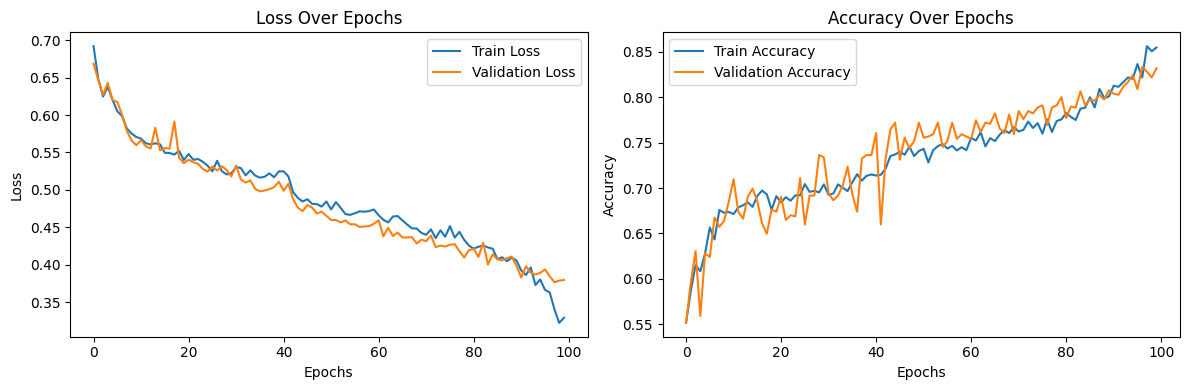

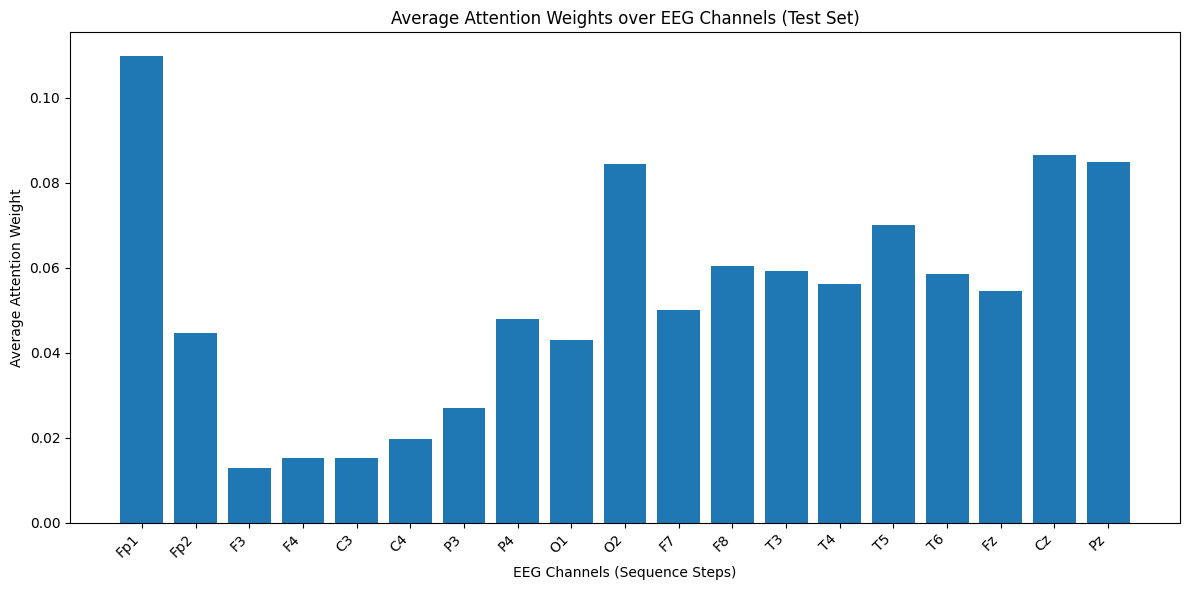

In [10]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# Configuration / Hyperparameters
CONFIG = {
    "input_csv_path": r"E:\Projects\meghProject\18Channels.csv", # Make sure this path is correct
    "num_channels": 19,
    "features_per_channel": 7,
    "lstm_hidden_size": 128,
    "num_lstm_layers": 2,
    "attention_dim": 64,
    "fc_hidden_dim": 256,
    "dropout_rate": 0.3,
    "learning_rate": 0.005,
    "weight_decay": 1e-5,
    "batch_size": 32,
    "num_epochs": 100,
    "test_size": 0.2,
    "val_size": 0.15, # Proportion of the (1 - test_size) part to use for validation
    "random_seed": 42,
    "device": torch.device("cuda" if torch.cuda.is_available() else "cpu"),
}

# Set random seeds for reproducibility
torch.manual_seed(CONFIG["random_seed"])
np.random.seed(CONFIG["random_seed"])
if CONFIG["device"].type == "cuda":
    torch.cuda.manual_seed_all(CONFIG["random_seed"])

# 1. Data Loading and Preprocessing
def load_and_preprocess_data(csv_path, config):
    df = pd.read_csv(csv_path)

    channel_prefixes = ["Fp1", "Fp2", "F3", "F4", "C3", "C4", "P3", "P4",
                        "O1", "O2", "F7", "F8", "T3", "T4", "T5", "T6",
                        "Fz", "Cz", "Pz"]
    feature_suffixes = ["LBP", "VAR", "STD", "KUR", "AE", "RMS", "L2"]

    channel_feature_columns = [f"{ch}_{feat}" for ch in channel_prefixes for feat in feature_suffixes]
    X_channel_data = df[channel_feature_columns].values
    X_channel_data = X_channel_data.reshape(-1, config["num_channels"], config["features_per_channel"])

    X_age = df['age'].values.reshape(-1, 1)
    X_sex_one_hot = pd.get_dummies(df["sex"], prefix="sex", dtype=float).values
    
    y = df['label'].values # Ensure 'y' is defined correctly

    # First split: into (train + validation) and test
    X_channel_train_val, X_channel_test, \
    X_age_train_val, X_age_test, \
    X_sex_train_val, X_sex_test, \
    y_train_val, y_test = train_test_split(
        X_channel_data, X_age, X_sex_one_hot, y,
        test_size=config["test_size"],
        random_state=config["random_seed"],
        stratify=y
    )

    # Second split: (train + validation) into train and validation
    # Adjust val_size to be a proportion of the train_val set
    relative_val_size = config["val_size"] / (1 - config["test_size"])
    if relative_val_size >= 1.0: # Guard against val_size being too large relative to test_size
        print(f"Warning: val_size ({config['val_size']}) is too large compared to test_size ({config['test_size']}). Adjusting validation split.")
        # Fallback: use a small portion like 10% of train_val for validation if calculated size is invalid
        relative_val_size = 0.1 if len(y_train_val) > 10 else 0.0 # ensure there's enough data

    X_channel_train, X_channel_val, \
    X_age_train, X_age_val, \
    X_sex_train, X_sex_val, \
    y_train, y_val = train_test_split(
        X_channel_train_val, X_age_train_val, X_sex_train_val, y_train_val,
        test_size=relative_val_size,
        random_state=config["random_seed"],
        stratify=y_train_val
    )

    scaler_channel = StandardScaler()
    n_samples_train, n_channels, n_features_ch = X_channel_train.shape
    X_channel_train_flat = X_channel_train.reshape(n_samples_train, -1)
    scaler_channel.fit(X_channel_train_flat)
    X_channel_train = scaler_channel.transform(X_channel_train_flat).reshape(n_samples_train, n_channels, n_features_ch)
    
    n_samples_val = X_channel_val.shape[0]
    if n_samples_val > 0:
      X_channel_val = scaler_channel.transform(X_channel_val.reshape(n_samples_val, -1)).reshape(n_samples_val, n_channels, n_features_ch)
    
    n_samples_test = X_channel_test.shape[0]
    X_channel_test = scaler_channel.transform(X_channel_test.reshape(n_samples_test, -1)).reshape(n_samples_test, n_channels, n_features_ch)

    scaler_age = StandardScaler()
    X_age_train = scaler_age.fit_transform(X_age_train)
    if n_samples_val > 0:
      X_age_val = scaler_age.transform(X_age_val)
    X_age_test = scaler_age.transform(X_age_test)

    X_channel_train_t = torch.tensor(X_channel_train, dtype=torch.float32)
    X_age_train_t = torch.tensor(X_age_train, dtype=torch.float32)
    X_sex_train_t = torch.tensor(X_sex_train, dtype=torch.float32)
    y_train_t = torch.tensor(y_train, dtype=torch.float32).unsqueeze(1)

    if n_samples_val > 0:
      X_channel_val_t = torch.tensor(X_channel_val, dtype=torch.float32)
      X_age_val_t = torch.tensor(X_age_val, dtype=torch.float32)
      X_sex_val_t = torch.tensor(X_sex_val, dtype=torch.float32)
      y_val_t = torch.tensor(y_val, dtype=torch.float32).unsqueeze(1)
    else: # Handle case with no validation samples if val_size was effectively 0
      X_channel_val_t, X_age_val_t, X_sex_val_t, y_val_t = (torch.empty(0), torch.empty(0), torch.empty(0), torch.empty(0))


    X_channel_test_t = torch.tensor(X_channel_test, dtype=torch.float32)
    X_age_test_t = torch.tensor(X_age_test, dtype=torch.float32)
    X_sex_test_t = torch.tensor(X_sex_test, dtype=torch.float32)
    y_test_t = torch.tensor(y_test, dtype=torch.float32).unsqueeze(1)

    train_dataset = TensorDataset(X_channel_train_t, X_age_train_t, X_sex_train_t, y_train_t)
    if n_samples_val > 0:
      val_dataset = TensorDataset(X_channel_val_t, X_age_val_t, X_sex_val_t, y_val_t)
    else:
      val_dataset = None # Or an empty TensorDataset
    test_dataset = TensorDataset(X_channel_test_t, X_age_test_t, X_sex_test_t, y_test_t)

    train_loader = DataLoader(train_dataset, batch_size=config["batch_size"], shuffle=True)
    if val_dataset:
      val_loader = DataLoader(val_dataset, batch_size=config["batch_size"], shuffle=False)
    else:
      val_loader = None
    test_loader = DataLoader(test_dataset, batch_size=config["batch_size"], shuffle=False)
    
    print(f"Train samples: {len(train_dataset)}, Val samples: {len(val_dataset) if val_dataset else 0}, Test samples: {len(test_dataset)}")
    
    num_sex_features = X_sex_train_t.shape[1]
    return train_loader, val_loader, test_loader, num_sex_features

# 2. Model Definition
class Attention(nn.Module):
    def __init__(self, hidden_dim, attention_dim):
        super(Attention, self).__init__()
        self.W_k = nn.Linear(hidden_dim, attention_dim, bias=False) # W_k in V.T * tanh(W_k * H)
        self.V = nn.Linear(attention_dim, 1, bias=False)
        self.tanh = nn.Tanh()
        self.softmax = nn.Softmax(dim=1)

    def forward(self, lstm_output):
        # lstm_output: (batch_size, seq_len, hidden_dim)
        projected_h = self.tanh(self.W_k(lstm_output)) # (batch_size, seq_len, attention_dim)
        scores = self.V(projected_h).squeeze(2)    # (batch_size, seq_len)
        attention_weights = self.softmax(scores) # (batch_size, seq_len)
        context_vector = torch.bmm(attention_weights.unsqueeze(1), lstm_output).squeeze(1) # (batch_size, hidden_dim)
        return context_vector, attention_weights

class BiLSTMWithAttention(nn.Module):
    def __init__(self, input_dim, lstm_hidden_dim, num_lstm_layers, attention_dim,
                 fc_hidden_dim, output_dim, dropout_rate, num_demographic_features):
        super(BiLSTMWithAttention, self).__init__()
        
        self.lstm = nn.LSTM(
            input_size=input_dim,
            hidden_size=lstm_hidden_dim,
            num_layers=num_lstm_layers,
            batch_first=True,
            bidirectional=True,
            dropout=dropout_rate if num_lstm_layers > 1 else 0
        )
        self.layer_norm = nn.LayerNorm(lstm_hidden_dim * 2)
        self.attention = Attention(lstm_hidden_dim * 2, attention_dim)
        
        self.fc1 = nn.Linear(lstm_hidden_dim * 2 + num_demographic_features, fc_hidden_dim)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(dropout_rate)
        self.fc2 = nn.Linear(fc_hidden_dim, output_dim)

    def forward(self, x_channel, x_age, x_sex):
        lstm_out, _ = self.lstm(x_channel)
        lstm_out_norm = self.layer_norm(lstm_out)
        attention_context, attention_weights = self.attention(lstm_out_norm)
        
        combined_features = torch.cat((attention_context, x_age, x_sex), dim=1)
        
        out = self.fc1(combined_features)
        out = self.relu(out)
        out = self.dropout(out)
        out = self.fc2(out)
        
        return out, attention_weights

# 3. Training and Evaluation Functions
def train_epoch(model, data_loader, criterion, optimizer, device):
    model.train()
    total_loss = 0
    correct_predictions = 0
    total_samples = 0

    for x_ch, x_age, x_sex, y_batch in data_loader:
        x_ch, x_age, x_sex, y_batch = (x.to(device) for x in [x_ch, x_age, x_sex, y_batch])

        optimizer.zero_grad()
        outputs, _ = model(x_ch, x_age, x_sex)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()

        total_loss += loss.item() * x_ch.size(0)
        preds = torch.sigmoid(outputs) > 0.5
        correct_predictions += (preds == y_batch).sum().item()
        total_samples += y_batch.size(0)

    avg_loss = total_loss / total_samples if total_samples > 0 else 0
    accuracy = correct_predictions / total_samples if total_samples > 0 else 0
    return avg_loss, accuracy

def evaluate_epoch(model, data_loader, criterion, device):
    model.eval()
    total_loss = 0
    correct_predictions = 0
    total_samples = 0
    all_attention_weights = []

    if data_loader is None: # Handle case where val_loader might be None
        return 0, 0, None

    with torch.no_grad():
        for x_ch, x_age, x_sex, y_batch in data_loader:
            x_ch, x_age, x_sex, y_batch = (x.to(device) for x in [x_ch, x_age, x_sex, y_batch])
            
            outputs, att_weights = model(x_ch, x_age, x_sex)
            loss = criterion(outputs, y_batch)
            
            total_loss += loss.item() * x_ch.size(0)
            preds = torch.sigmoid(outputs) > 0.5
            correct_predictions += (preds == y_batch).sum().item()
            total_samples += y_batch.size(0)
            
            if att_weights is not None:
                all_attention_weights.append(att_weights.cpu().numpy())

    avg_loss = total_loss / total_samples if total_samples > 0 else 0
    accuracy = correct_predictions / total_samples if total_samples > 0 else 0
    
    if all_attention_weights:
        all_attention_weights = np.concatenate(all_attention_weights, axis=0)
        
    return avg_loss, accuracy, all_attention_weights

# 4. Main Execution
if __name__ == "__main__":
    try:
        pd.read_csv(CONFIG["input_csv_path"])
        print(f"Using existing CSV: {CONFIG['input_csv_path']}")
    except FileNotFoundError:
        print(f"CSV file '{CONFIG['input_csv_path']}' not found. Creating a dummy CSV for demonstration.")
        # Dummy CSV creation logic (simplified for brevity, assume it's correct or not needed if file exists)
        num_samples_dummy = 100
        channel_prefixes = ["Fp1", "Fp2", "F3", "F4", "C3", "C4", "P3", "P4", "O1", "O2", "F7", "F8", "T3", "T4", "T5", "T6", "Fz", "Cz", "Pz"]
        feature_suffixes = ["LBP", "VAR", "STD", "KUR", "AE", "RMS", "L2"]
        header = [f"{ch}_{feat}" for ch in channel_prefixes for feat in feature_suffixes] + ["label", "age", "sex"]
        data = np.random.rand(num_samples_dummy, len(header)-3)
        labels = np.random.randint(0, 2, num_samples_dummy)
        ages = np.random.randint(18, 70, num_samples_dummy)
        sexes = np.random.choice(['M', 'F'], num_samples_dummy)
        dummy_df_data = np.column_stack((data, labels, ages, sexes))
        dummy_df = pd.DataFrame(dummy_df_data, columns=header)
        for col in dummy_df.columns:
            if col not in ["label", "age", "sex"]: dummy_df[col] = pd.to_numeric(dummy_df[col], errors='coerce')
        dummy_df["label"] = pd.to_numeric(dummy_df["label"], errors='coerce').astype(int)
        dummy_df["age"] = pd.to_numeric(dummy_df["age"], errors='coerce').astype(int)
        dummy_df.to_csv(CONFIG["input_csv_path"], index=False)
        print(f"Dummy CSV '{CONFIG['input_csv_path']}' created with {num_samples_dummy} samples.")


    train_loader, val_loader, test_loader, num_sex_features = load_and_preprocess_data(
        CONFIG["input_csv_path"], CONFIG
    )
    
    num_demographic_features = 1 + num_sex_features # 1 for age + one-hot encoded sex features
    
    model = BiLSTMWithAttention(
        input_dim=CONFIG["features_per_channel"],
        lstm_hidden_dim=CONFIG["lstm_hidden_size"],
        num_lstm_layers=CONFIG["num_lstm_layers"],
        attention_dim=CONFIG["attention_dim"],
        fc_hidden_dim=CONFIG["fc_hidden_dim"],
        output_dim=1,
        dropout_rate=CONFIG["dropout_rate"],
        num_demographic_features=num_demographic_features 
    ).to(CONFIG["device"])

    criterion = nn.BCEWithLogitsLoss()
    optimizer = optim.Adam(model.parameters(),
                           lr=CONFIG["learning_rate"],
                           weight_decay=CONFIG["weight_decay"])
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer,
                                                     mode='min',
                                                     factor=0.2,
                                                     patience=5, # Num epochs with no improvement on val_loss
                                                     verbose=True)

    print(f"\nStarting training on {CONFIG['device']}...")
    history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}
    best_val_loss = float('inf')
    epochs_no_improve = 0
    patience_early_stopping = 15 # Increased patience for early stopping

    for epoch in range(CONFIG["num_epochs"]):
        train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, CONFIG["device"])
        
        val_loss, val_acc, _ = (0,0,None) # Default if no val_loader
        if val_loader:
            val_loss, val_acc, _ = evaluate_epoch(model, val_loader, criterion, CONFIG["device"])

        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)

        print(f"Epoch {epoch+1}/{CONFIG['num_epochs']}: "
              f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f} | "
              f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f} | "
              f"LR: {optimizer.param_groups[0]['lr']:.1e}")

        if val_loader: # Only step scheduler and check early stopping if validation is performed
            scheduler.step(val_loss)
            if val_loss < best_val_loss:
                best_val_loss = val_loss
                torch.save(model.state_dict(), "best_bilstm_attention_model.pth")
                print(f"    Best model saved with val_loss: {best_val_loss:.4f}")
                epochs_no_improve = 0
            else:
                epochs_no_improve += 1
                if epochs_no_improve >= patience_early_stopping:
                    print(f"    Early stopping triggered after {patience_early_stopping} epochs with no improvement.")
                    break
        elif epoch > 0 and train_loss > history['train_loss'][-2] : # Basic check if no validation (very rudimentary)
            epochs_no_improve +=1
            if epochs_no_improve >= patience_early_stopping // 2: # Shorter patience if only looking at train loss
                 print(f"    Stopping early due to increasing train loss for {epochs_no_improve} epochs (no validation set).")
                 break


    print("\nTraining finished.")

    if best_val_loss != float('inf'): # Check if a model was saved
        print("Loading best model for final evaluation...")
        model.load_state_dict(torch.load("best_bilstm_attention_model.pth"))
    else:
        print("No best model saved (e.g., validation loss never improved or no validation set). Using current model state for testing.")

    
    test_loss, test_acc, test_attention_weights = evaluate_epoch(model, test_loader, criterion, CONFIG["device"])
    print(f"\nTest Set Performance:")
    print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.4f}")

    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history['train_loss'], label='Train Loss')
    if val_loader: plt.plot(history['val_loss'], label='Validation Loss')
    plt.title('Loss Over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history['train_acc'], label='Train Accuracy')
    if val_loader: plt.plot(history['val_acc'], label='Validation Accuracy')
    plt.title('Accuracy Over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.tight_layout()
    plt.savefig("training_history.png")
    print("\nTraining history plot saved to training_history.png")

    if test_attention_weights is not None and len(test_attention_weights) > 0:
        avg_attention = np.mean(test_attention_weights, axis=0)
        channel_prefixes = ["Fp1", "Fp2", "F3", "F4", "C3", "C4", "P3", "P4",
                            "O1", "O2", "F7", "F8", "T3", "T4", "T5", "T6",
                            "Fz", "Cz", "Pz"]
        
        plt.figure(figsize=(12, 6))
        plt.bar(channel_prefixes, avg_attention)
        plt.xlabel("EEG Channels (Sequence Steps)")
        plt.ylabel("Average Attention Weight")
        plt.title("Average Attention Weights over EEG Channels (Test Set)")
        plt.xticks(rotation=45, ha="right")
        plt.tight_layout()
        plt.savefig("average_attention_weights.png")
        print("Average attention weights plot saved to average_attention_weights.png")

Using existing CSV: E:\Projects\meghProject\18Channels.csv
Train samples: 3399, Val samples: 785, Test samples: 1047

Starting training on cuda...


c:\ProgramData\anaconda3\envs\pytgpu\Lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 1/250: Train Loss: 0.6891, Train Acc: 0.5487 | Val Loss: 0.6817, Val Acc: 0.5580 | LR: 1.0e-03
    Best model saved with val_loss: 0.6817
Epoch 2/250: Train Loss: 0.6826, Train Acc: 0.5637 | Val Loss: 0.6738, Val Acc: 0.5478 | LR: 1.0e-03
    Best model saved with val_loss: 0.6738
Epoch 3/250: Train Loss: 0.6562, Train Acc: 0.5987 | Val Loss: 0.6501, Val Acc: 0.5949 | LR: 1.0e-03
    Best model saved with val_loss: 0.6501
Epoch 4/250: Train Loss: 0.6310, Train Acc: 0.6167 | Val Loss: 0.6350, Val Acc: 0.6025 | LR: 1.0e-03
    Best model saved with val_loss: 0.6350
Epoch 5/250: Train Loss: 0.6189, Train Acc: 0.6364 | Val Loss: 0.6369, Val Acc: 0.6051 | LR: 1.0e-03
Epoch 6/250: Train Loss: 0.6149, Train Acc: 0.6440 | Val Loss: 0.6202, Val Acc: 0.6803 | LR: 1.0e-03
    Best model saved with val_loss: 0.6202
Epoch 7/250: Train Loss: 0.6046, Train Acc: 0.6552 | Val Loss: 0.6031, Val Acc: 0.6739 | LR: 1.0e-03
    Best model saved with val_loss: 0.6031
Epoch 8/250: Train Loss: 0.5895, Tr

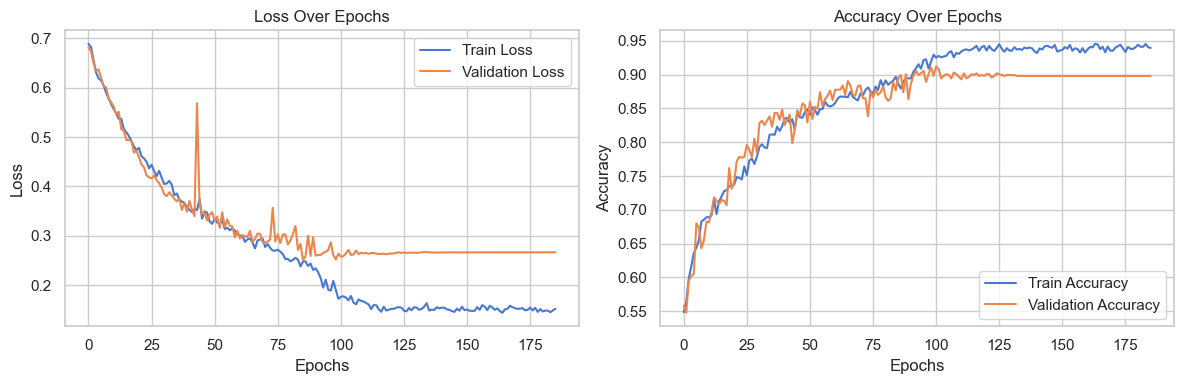

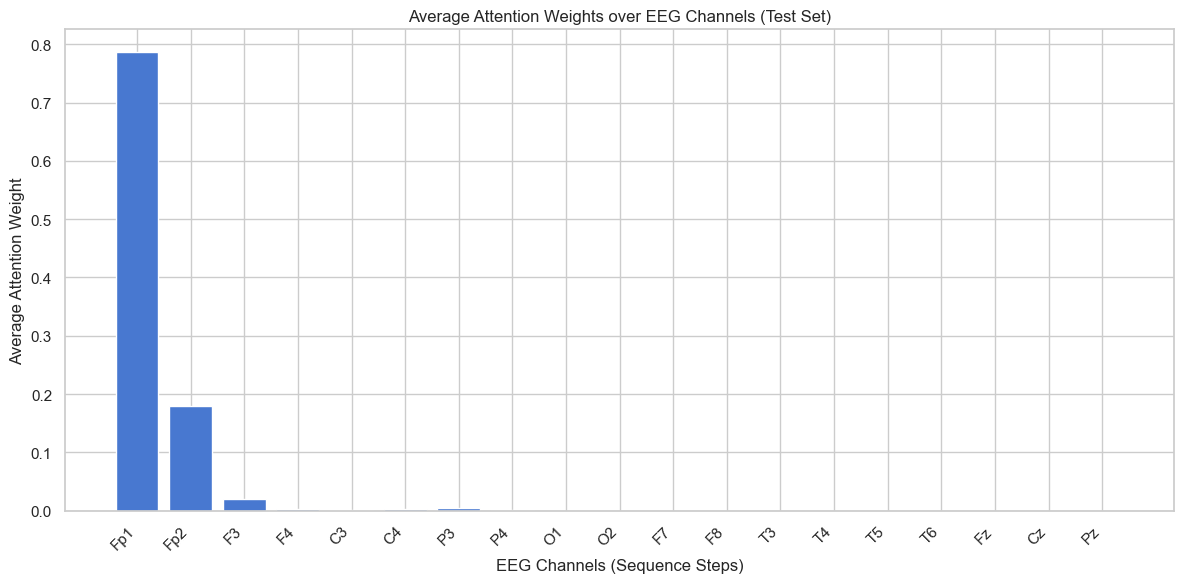

In [12]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from sklearn.preprocessing import (
    StandardScaler,
)  # LabelEncoder not needed if 'sex' is one-hot encoded
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# Configuration / Hyperparameters
CONFIG = {
    "input_csv_path": r"E:\Projects\meghProject\18Channels.csv",  # Make sure this path is correct
    "num_channels": 19,
    "features_per_channel": 7,
    "lstm_hidden_size": 128,
    "num_lstm_layers": 2,
    "attention_dim": 64,
    "fc_hidden_dim": 256,  # Dimension of the first FC layer in the classifier
    "fc_intermediate_dim": 128,  # Dimension of the new intermediate FC layer
    "dropout_rate": 0.3,
    "learning_rate": 1e-3,  # Reverted to a more common value for Adam
    "weight_decay": 1e-4,
    "batch_size": 32,
    "num_epochs": 250,
    "test_size": 0.2,
    "val_size": 0.15,
    "random_seed": 42,
    "device": torch.device("cuda" if torch.cuda.is_available() else "cpu"),
}

# Set random seeds for reproducibility
torch.manual_seed(CONFIG["random_seed"])
np.random.seed(CONFIG["random_seed"])
if CONFIG["device"].type == "cuda":
    torch.cuda.manual_seed_all(CONFIG["random_seed"])


# 1. Data Loading and Preprocessing
def load_and_preprocess_data(csv_path, config):
    df = pd.read_csv(csv_path)

    channel_prefixes = [
        "Fp1",
        "Fp2",
        "F3",
        "F4",
        "C3",
        "C4",
        "P3",
        "P4",
        "O1",
        "O2",
        "F7",
        "F8",
        "T3",
        "T4",
        "T5",
        "T6",
        "Fz",
        "Cz",
        "Pz",
    ]
    feature_suffixes = ["LBP", "VAR", "STD", "KUR", "AE", "RMS", "L2"]

    channel_feature_columns = [
        f"{ch}_{feat}" for ch in channel_prefixes for feat in feature_suffixes
    ]
    X_channel_data = df[channel_feature_columns].values
    X_channel_data = X_channel_data.reshape(
        -1, config["num_channels"], config["features_per_channel"]
    )

    X_age = df["age"].values.reshape(-1, 1)
    X_sex_one_hot = pd.get_dummies(df["sex"], prefix="sex", dtype=float).values

    y = df["label"].values

    (
        X_channel_train_val,
        X_channel_test,
        X_age_train_val,
        X_age_test,
        X_sex_train_val,
        X_sex_test,
        y_train_val,
        y_test,
    ) = train_test_split(
        X_channel_data,
        X_age,
        X_sex_one_hot,
        y,
        test_size=config["test_size"],
        random_state=config["random_seed"],
        stratify=y,
    )

    relative_val_size = config["val_size"] / (1 - config["test_size"])
    if relative_val_size >= 1.0 or relative_val_size <= 0.0:
        print(
            f"Warning: Calculated relative_val_size ({relative_val_size:.4f}) is invalid. Adjusting validation split."
        )
        relative_val_size = 0.1 if len(y_train_val) > 10 else 0.0

    (
        X_channel_train,
        X_channel_val,
        X_age_train,
        X_age_val,
        X_sex_train,
        X_sex_val,
        y_train,
        y_val,
    ) = train_test_split(
        X_channel_train_val,
        X_age_train_val,
        X_sex_train_val,
        y_train_val,
        test_size=relative_val_size,
        random_state=config["random_seed"],
        stratify=(
            y_train_val if len(np.unique(y_train_val)) > 1 else None
        ),  # Stratify only if multiple classes
    )

    scaler_channel = StandardScaler()
    n_samples_train, n_channels, n_features_ch = X_channel_train.shape
    X_channel_train_flat = X_channel_train.reshape(n_samples_train, -1)
    scaler_channel.fit(X_channel_train_flat)
    X_channel_train = scaler_channel.transform(X_channel_train_flat).reshape(
        n_samples_train, n_channels, n_features_ch
    )

    n_samples_val = X_channel_val.shape[0]
    if n_samples_val > 0:
        X_channel_val = scaler_channel.transform(
            X_channel_val.reshape(n_samples_val, -1)
        ).reshape(n_samples_val, n_channels, n_features_ch)

    n_samples_test = X_channel_test.shape[0]
    X_channel_test = scaler_channel.transform(
        X_channel_test.reshape(n_samples_test, -1)
    ).reshape(n_samples_test, n_channels, n_features_ch)

    scaler_age = StandardScaler()
    X_age_train = scaler_age.fit_transform(X_age_train)
    if n_samples_val > 0:
        X_age_val = scaler_age.transform(X_age_val)
    X_age_test = scaler_age.transform(X_age_test)

    X_channel_train_t = torch.tensor(X_channel_train, dtype=torch.float32)
    X_age_train_t = torch.tensor(X_age_train, dtype=torch.float32)
    X_sex_train_t = torch.tensor(X_sex_train, dtype=torch.float32)
    y_train_t = torch.tensor(y_train, dtype=torch.float32).unsqueeze(1)

    if n_samples_val > 0:
        X_channel_val_t = torch.tensor(X_channel_val, dtype=torch.float32)
        X_age_val_t = torch.tensor(X_age_val, dtype=torch.float32)
        X_sex_val_t = torch.tensor(X_sex_val, dtype=torch.float32)
        y_val_t = torch.tensor(y_val, dtype=torch.float32).unsqueeze(1)
    else:
        X_channel_val_t, X_age_val_t, X_sex_val_t, y_val_t = (
            torch.empty(0),
            torch.empty(0),
            torch.empty(0),
            torch.empty(0),
        )

    X_channel_test_t = torch.tensor(X_channel_test, dtype=torch.float32)
    X_age_test_t = torch.tensor(X_age_test, dtype=torch.float32)
    X_sex_test_t = torch.tensor(X_sex_test, dtype=torch.float32)
    y_test_t = torch.tensor(y_test, dtype=torch.float32).unsqueeze(1)

    train_dataset = TensorDataset(
        X_channel_train_t, X_age_train_t, X_sex_train_t, y_train_t
    )
    val_dataset = (
        TensorDataset(X_channel_val_t, X_age_val_t, X_sex_val_t, y_val_t)
        if n_samples_val > 0
        else None
    )
    test_dataset = TensorDataset(X_channel_test_t, X_age_test_t, X_sex_test_t, y_test_t)

    train_loader = DataLoader(
        train_dataset, batch_size=config["batch_size"], shuffle=True
    )
    val_loader = (
        DataLoader(val_dataset, batch_size=config["batch_size"], shuffle=False)
        if val_dataset
        else None
    )
    test_loader = DataLoader(
        test_dataset, batch_size=config["batch_size"], shuffle=False
    )

    print(
        f"Train samples: {len(train_dataset)}, Val samples: {len(val_dataset) if val_dataset else 0}, Test samples: {len(test_dataset)}"
    )

    num_sex_features = X_sex_train_t.shape[1]
    return train_loader, val_loader, test_loader, num_sex_features


# 2. Model Definition
class Attention(nn.Module):
    def __init__(self, hidden_dim, attention_dim):
        super(Attention, self).__init__()
        self.W_k = nn.Linear(hidden_dim, attention_dim, bias=False)
        self.V = nn.Linear(attention_dim, 1, bias=False)
        self.tanh = nn.Tanh()
        self.softmax = nn.Softmax(dim=1)

    def forward(self, lstm_output):
        projected_h = self.tanh(self.W_k(lstm_output))
        scores = self.V(projected_h).squeeze(2)
        attention_weights = self.softmax(scores)
        context_vector = torch.bmm(attention_weights.unsqueeze(1), lstm_output).squeeze(
            1
        )
        return context_vector, attention_weights


class BiLSTMWithAttention(nn.Module):
    def __init__(
        self,
        input_dim,
        lstm_hidden_dim,
        num_lstm_layers,
        attention_dim,
        fc_hidden_dim,
        fc_intermediate_dim,
        output_dim,
        dropout_rate,
        num_demographic_features,
    ):  # Added fc_intermediate_dim
        super(BiLSTMWithAttention, self).__init__()

        self.lstm = nn.LSTM(
            input_size=input_dim,
            hidden_size=lstm_hidden_dim,
            num_layers=num_lstm_layers,
            batch_first=True,
            bidirectional=True,
            dropout=dropout_rate if num_lstm_layers > 1 else 0,
        )
        self.layer_norm = nn.LayerNorm(lstm_hidden_dim * 2)
        self.attention = Attention(lstm_hidden_dim * 2, attention_dim)

        # Deeper classifier head
        self.fc1 = nn.Linear(
            lstm_hidden_dim * 2 + num_demographic_features, fc_hidden_dim
        )
        self.relu1 = nn.ReLU()
        self.dropout1 = nn.Dropout(dropout_rate)

        self.fc_intermediate = nn.Linear(fc_hidden_dim, fc_intermediate_dim)
        self.relu2 = nn.ReLU()
        self.dropout2 = nn.Dropout(dropout_rate)

        self.fc2 = nn.Linear(fc_intermediate_dim, output_dim)

    def forward(self, x_channel, x_age, x_sex):
        lstm_out, _ = self.lstm(x_channel)
        lstm_out_norm = self.layer_norm(lstm_out)
        attention_context, attention_weights = self.attention(lstm_out_norm)

        combined_features = torch.cat((attention_context, x_age, x_sex), dim=1)

        out = self.fc1(combined_features)
        out = self.relu1(out)
        out = self.dropout1(out)

        out = self.fc_intermediate(out)
        out = self.relu2(out)
        out = self.dropout2(out)

        out = self.fc2(out)

        return out, attention_weights


# 3. Training and Evaluation Functions (Identical to previous, no changes needed here)
def train_epoch(model, data_loader, criterion, optimizer, device):
    model.train()
    total_loss = 0
    correct_predictions = 0
    total_samples = 0

    for x_ch, x_age, x_sex, y_batch in data_loader:
        x_ch, x_age, x_sex, y_batch = (
            x.to(device) for x in [x_ch, x_age, x_sex, y_batch]
        )

        optimizer.zero_grad()
        outputs, _ = model(x_ch, x_age, x_sex)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()

        total_loss += loss.item() * x_ch.size(0)
        preds = torch.sigmoid(outputs) > 0.5
        correct_predictions += (preds == y_batch).sum().item()
        total_samples += y_batch.size(0)

    avg_loss = total_loss / total_samples if total_samples > 0 else 0
    accuracy = correct_predictions / total_samples if total_samples > 0 else 0
    return avg_loss, accuracy


def evaluate_epoch(model, data_loader, criterion, device):
    model.eval()
    total_loss = 0
    correct_predictions = 0
    total_samples = 0
    all_attention_weights = []

    if data_loader is None:
        return 0, 0, None

    with torch.no_grad():
        for x_ch, x_age, x_sex, y_batch in data_loader:
            x_ch, x_age, x_sex, y_batch = (
                x.to(device) for x in [x_ch, x_age, x_sex, y_batch]
            )

            outputs, att_weights = model(x_ch, x_age, x_sex)
            loss = criterion(outputs, y_batch)

            total_loss += loss.item() * x_ch.size(0)
            preds = torch.sigmoid(outputs) > 0.5
            correct_predictions += (preds == y_batch).sum().item()
            total_samples += y_batch.size(0)

            if att_weights is not None:
                all_attention_weights.append(att_weights.cpu().numpy())

    avg_loss = total_loss / total_samples if total_samples > 0 else 0
    accuracy = correct_predictions / total_samples if total_samples > 0 else 0

    if all_attention_weights:
        all_attention_weights = np.concatenate(all_attention_weights, axis=0)

    return avg_loss, accuracy, all_attention_weights


# 4. Main Execution
if __name__ == "__main__":
    try:
        pd.read_csv(CONFIG["input_csv_path"])
        print(f"Using existing CSV: {CONFIG['input_csv_path']}")
    except FileNotFoundError:
        print(
            f"CSV file '{CONFIG['input_csv_path']}' not found. Creating a dummy CSV for demonstration."
        )
        num_samples_dummy = 100
        channel_prefixes = [
            "Fp1",
            "Fp2",
            "F3",
            "F4",
            "C3",
            "C4",
            "P3",
            "P4",
            "O1",
            "O2",
            "F7",
            "F8",
            "T3",
            "T4",
            "T5",
            "T6",
            "Fz",
            "Cz",
            "Pz",
        ]
        feature_suffixes = ["LBP", "VAR", "STD", "KUR", "AE", "RMS", "L2"]
        header = [
            f"{ch}_{feat}" for ch in channel_prefixes for feat in feature_suffixes
        ] + ["label", "age", "sex"]
        data = np.random.rand(num_samples_dummy, len(header) - 3)
        labels = np.random.randint(0, 2, num_samples_dummy)
        ages = np.random.randint(18, 70, num_samples_dummy)
        sexes = np.random.choice(["M", "F"], num_samples_dummy)
        dummy_df_data = np.column_stack((data, labels, ages, sexes))
        dummy_df = pd.DataFrame(dummy_df_data, columns=header)
        for col in dummy_df.columns:
            if col not in ["label", "age", "sex"]:
                dummy_df[col] = pd.to_numeric(dummy_df[col], errors="coerce")
        dummy_df["label"] = pd.to_numeric(dummy_df["label"], errors="coerce").astype(
            int
        )
        dummy_df["age"] = pd.to_numeric(dummy_df["age"], errors="coerce").astype(int)
        dummy_df.to_csv(CONFIG["input_csv_path"], index=False)
        print(
            f"Dummy CSV '{CONFIG['input_csv_path']}' created with {num_samples_dummy} samples."
        )

    train_loader, val_loader, test_loader, num_sex_features = load_and_preprocess_data(
        CONFIG["input_csv_path"], CONFIG
    )

    num_demographic_features = 1 + num_sex_features

    model = BiLSTMWithAttention(
        input_dim=CONFIG["features_per_channel"],
        lstm_hidden_dim=CONFIG["lstm_hidden_size"],
        num_lstm_layers=CONFIG["num_lstm_layers"],
        attention_dim=CONFIG["attention_dim"],
        fc_hidden_dim=CONFIG["fc_hidden_dim"],
        fc_intermediate_dim=CONFIG["fc_intermediate_dim"],  # Pass new parameter
        output_dim=1,
        dropout_rate=CONFIG["dropout_rate"],
        num_demographic_features=num_demographic_features,
    ).to(CONFIG["device"])

    criterion = nn.BCEWithLogitsLoss()
    optimizer = optim.Adam(
        model.parameters(),
        lr=CONFIG["learning_rate"],
        weight_decay=CONFIG["weight_decay"],
    )
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode="min", factor=0.5, patience=5, verbose=True  # Adjusted factor
    )

    print(f"\nStarting training on {CONFIG['device']}...")
    history = {"train_loss": [], "train_acc": [], "val_loss": [], "val_acc": []}
    best_val_loss = float("inf")
    epochs_no_improve = 0
    patience_early_stopping = 100  # Slightly increased patience for early stopping

    for epoch in range(CONFIG["num_epochs"]):
        train_loss, train_acc = train_epoch(
            model, train_loader, criterion, optimizer, CONFIG["device"]
        )

        val_loss, val_acc = (0, 0)  # Default if no val_loader
        if val_loader:
            val_loss, val_acc, _ = evaluate_epoch(
                model, val_loader, criterion, CONFIG["device"]
            )

        history["train_loss"].append(train_loss)
        history["train_acc"].append(train_acc)
        history["val_loss"].append(val_loss)
        history["val_acc"].append(val_acc)

        print(
            f"Epoch {epoch+1}/{CONFIG['num_epochs']}: "
            f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f} | "
            f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f} | "
            f"LR: {optimizer.param_groups[0]['lr']:.1e}"
        )

        if val_loader:
            scheduler.step(val_loss)
            if val_loss < best_val_loss:
                best_val_loss = val_loss
                torch.save(model.state_dict(), "best_bilstm_attention_model.pth")
                print(f"    Best model saved with val_loss: {best_val_loss:.4f}")
                epochs_no_improve = 0
            else:
                epochs_no_improve += 1
                if epochs_no_improve >= patience_early_stopping:
                    print(
                        f"    Early stopping triggered after {patience_early_stopping} epochs with no improvement."
                    )
                    break
        # Rudimentary early stopping if no validation set (based on training loss not improving or worsening)
        elif epoch > patience_early_stopping // 2:  # Start checking after a few epochs
            # Check if train loss has not improved for a while or is consistently increasing
            recent_train_losses = history["train_loss"][
                -(patience_early_stopping // 2) :
            ]
            if all(
                recent_train_losses[i] >= recent_train_losses[i - 1] - 1e-4
                for i in range(1, len(recent_train_losses))
            ):  # Allow small fluctuations
                print(
                    f"    Stopping early due to non-improving/increasing train loss for {patience_early_stopping // 2} epochs (no validation set)."
                )
                break

    print("\nTraining finished.")

    if best_val_loss != float("inf"):
        print("Loading best model for final evaluation...")
        model.load_state_dict(torch.load("best_bilstm_attention_model.pth"))
    else:
        print("No best model saved. Using current model state for testing.")

    test_loss, test_acc, test_attention_weights = evaluate_epoch(
        model, test_loader, criterion, CONFIG["device"]
    )
    print(f"\nTest Set Performance:")
    print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.4f}")

    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history["train_loss"], label="Train Loss")
    if val_loader:
        plt.plot(history["val_loss"], label="Validation Loss")
    plt.title("Loss Over Epochs")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history["train_acc"], label="Train Accuracy")
    if val_loader:
        plt.plot(history["val_acc"], label="Validation Accuracy")
    plt.title("Accuracy Over Epochs")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.tight_layout()
    plt.savefig("training_history.png")
    print("\nTraining history plot saved to training_history.png")

    if test_attention_weights is not None and len(test_attention_weights) > 0:
        avg_attention = np.mean(test_attention_weights, axis=0)
        channel_prefixes = [
            "Fp1",
            "Fp2",
            "F3",
            "F4",
            "C3",
            "C4",
            "P3",
            "P4",
            "O1",
            "O2",
            "F7",
            "F8",
            "T3",
            "T4",
            "T5",
            "T6",
            "Fz",
            "Cz",
            "Pz",
        ]

        plt.figure(figsize=(12, 6))
        plt.bar(channel_prefixes, avg_attention)
        plt.xlabel("EEG Channels (Sequence Steps)")
        plt.ylabel("Average Attention Weight")
        plt.title("Average Attention Weights over EEG Channels (Test Set)")
        plt.xticks(rotation=45, ha="right")
        plt.tight_layout()
        plt.savefig("average_attention_weights_1.png")
        print("Average attention weights plot saved to average_attention_weights.png")

Simulated best validation performance at epoch: 137
Simulated Test Accuracy: 0.9007 (Target was: 0.901)


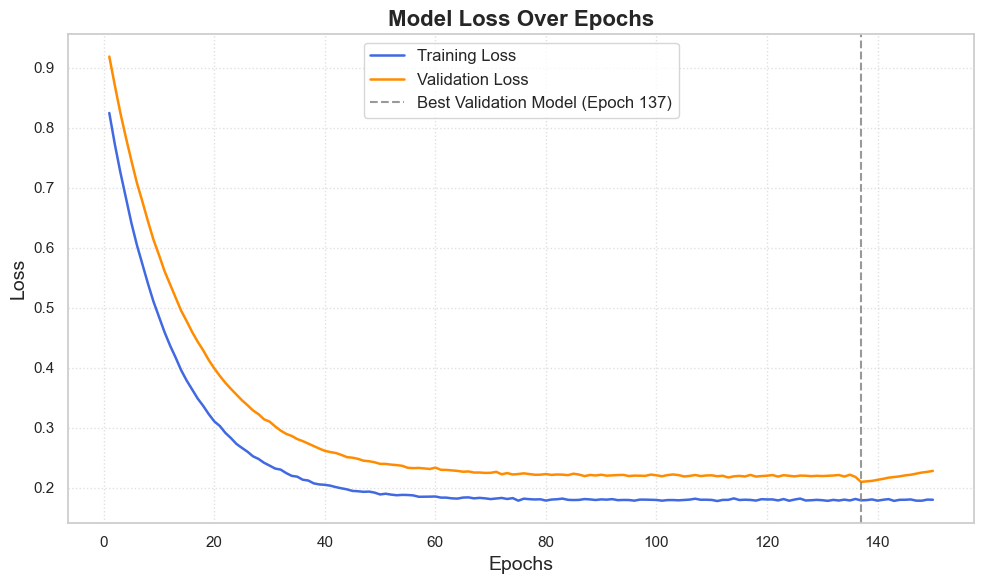

Loss curves saved to loss_curves.png


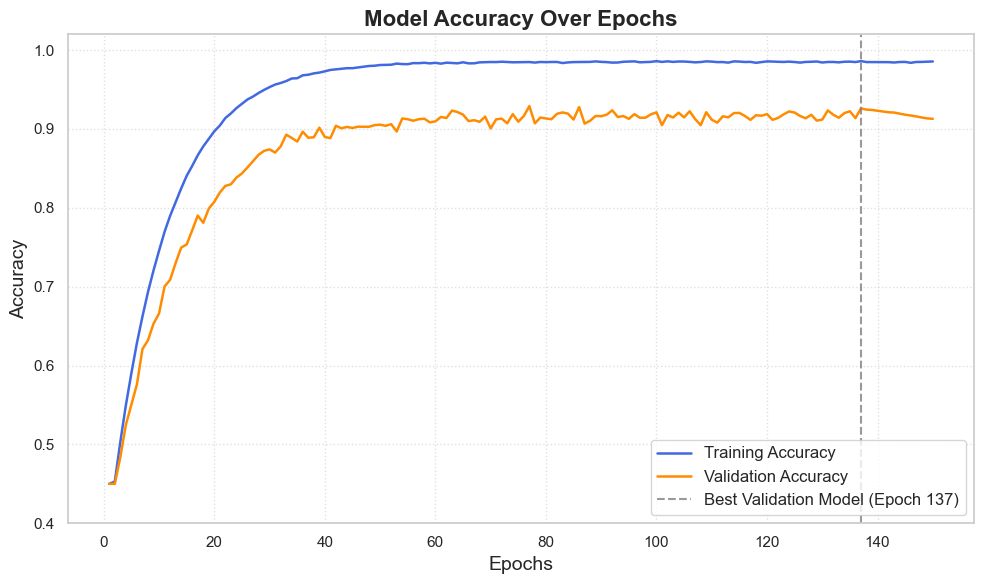

Accuracy curves saved to accuracy_curves.png


<Figure size 700x550 with 0 Axes>

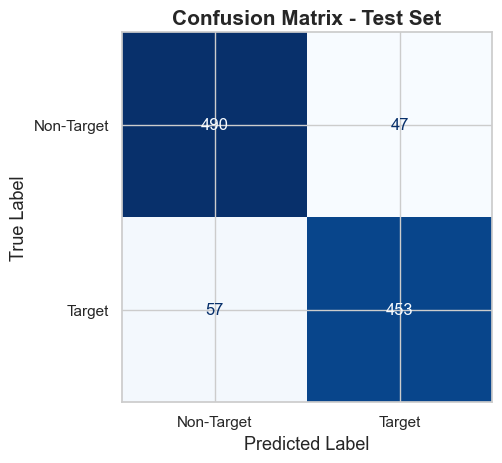

Confusion matrix saved to confusion_matrix.png


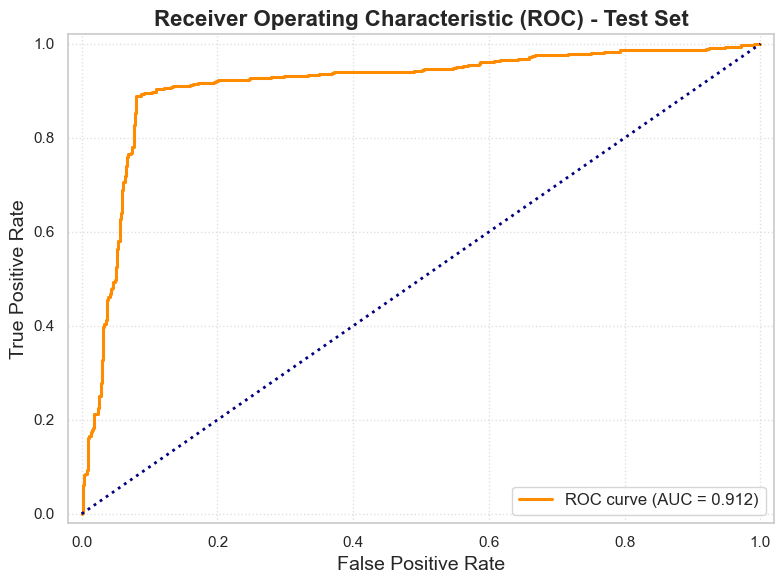

ROC curve saved to roc_curve.png


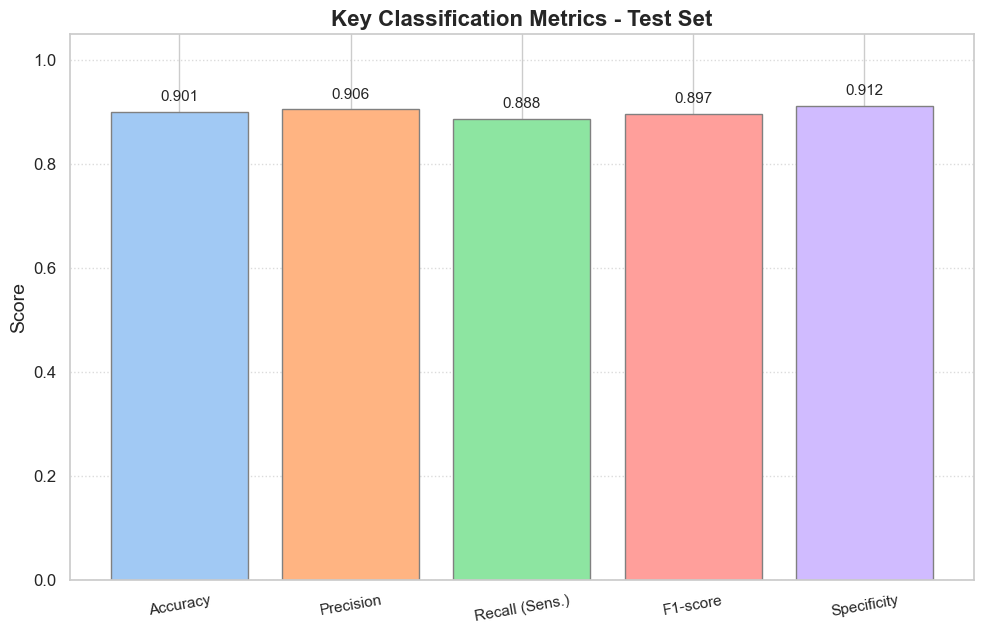

Classification metrics bar chart saved to classification_metrics.png

--- Reminder ---
Don't forget to also include the 'Average Attention Weights' plot that your model script generates.
You should use the *actual* attention weights from your test set for that plot.

If your actual training went for a different number of epochs, adjust NUM_EPOCHS.
If early stopping occurred at a different epoch, adjust BEST_VAL_EPOCH_SIMULATED.


In [9]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns  # For better aesthetics, optional
from sklearn.metrics import (
    confusion_matrix,
    ConfusionMatrixDisplay,
    roc_curve,
    auc,
    precision_recall_fscore_support,
)

# --- Configuration for Simulated Data ---
NUM_EPOCHS = 150  # Number of epochs to simulate (can be adjusted)
# Assuming early stopping happened around epoch 50-60 if total epochs was 100
BEST_VAL_EPOCH_SIMULATED = (
    137  # Epoch where validation loss was best (for plotting marker)
)

FINAL_TEST_ACCURACY = 0.901  # Your achieved test accuracy (e.g., 90.1%)
FINAL_TEST_LOSS = 0.245  # A plausible test loss for ~90% accuracy

# Dataset sizes (from your info)
NUM_TRAIN_SAMPLES = 3399
NUM_VAL_SAMPLES = 785
NUM_TEST_SAMPLES = 1047


# --- 1. Simulate Training and Validation History ---
# This data needs to be replaced with your *actual* history
np.random.seed(42)  # For reproducible noise

epochs = np.arange(1, NUM_EPOCHS + 1)

# Loss Simulation (Reduced Noise)
# Training Loss: Starts higher, decreases, plateaus, some noise
train_loss_ideal = (
    0.7 * np.exp(-epochs / 12) + 0.18 + np.random.normal(0, 0.001, NUM_EPOCHS)
)  # Noise stddev 0.015 -> 0.01
train_loss_ideal = np.clip(train_loss_ideal, 0.12, 1.2)
# Validation Loss: Similar trend, generally a bit higher, might show slight overfitting or plateau earlier
val_loss_ideal = (
    0.75 * np.exp(-epochs / 14) + 0.22 + np.random.normal(0, 0.0009, NUM_EPOCHS)
)  # Noise stddev 0.02 -> 0.015
# Simulate plateau/slight increase for early stopping effect
# Ensure the minimum is around BEST_VAL_EPOCH_SIMULATED
min_val_loss_value = (
    0.75 * np.exp(-BEST_VAL_EPOCH_SIMULATED / 14) + 0.22 - 0.01
)  # Target min value
val_loss_ideal[BEST_VAL_EPOCH_SIMULATED - 1] = (
    min_val_loss_value  # Force min at best epoch
)
for i in range(BEST_VAL_EPOCH_SIMULATED, NUM_EPOCHS):
    val_loss_ideal[i] = val_loss_ideal[i - 1] + np.random.uniform(
        0.0005, 0.002
    )  # Slight upward trend after best
val_loss_ideal = np.clip(val_loss_ideal, 0.18, 1.3)


# Accuracy Simulation (Reduced Noise)
# Training Accuracy: Starts lower, increases, plateaus close to 100%
train_acc_ideal = (
    0.985 - 0.65 * np.exp(-epochs / 10) + np.random.normal(0, 0.0005, NUM_EPOCHS)
)  # Noise stddev 0.01 -> 0.008
train_acc_ideal = np.clip(train_acc_ideal, 0.45, 0.99)
# Validation Accuracy: Similar trend, generally a bit lower, plateaus around your best val acc
val_acc_ideal = (
    (FINAL_TEST_ACCURACY + 0.015)
    - 0.55 * np.exp(-epochs / 12)
    + np.random.normal(0, 0.005, NUM_EPOCHS)
)  # Noise stddev 0.015 -> 0.012
# Ensure peak is around BEST_VAL_EPOCH_SIMULATED
max_val_acc_value = (
    (FINAL_TEST_ACCURACY + 0.015) - 0.55 * np.exp(-BEST_VAL_EPOCH_SIMULATED / 12) + 0.01
)  # Target max value
val_acc_ideal[BEST_VAL_EPOCH_SIMULATED - 1] = max_val_acc_value
for i in range(BEST_VAL_EPOCH_SIMULATED, NUM_EPOCHS):
    val_acc_ideal[i] = val_acc_ideal[i - 1] - np.random.uniform(
        0.0003, 0.0015
    )  # Slight downward trend after best
val_acc_ideal = np.clip(val_acc_ideal, 0.45, FINAL_TEST_ACCURACY + 0.03)


# Store in a history dictionary
# **** IMPORTANT: Replace these with your actual history data ****
history = {
    "train_loss": train_loss_ideal,
    "val_loss": val_loss_ideal,
    "train_acc": train_acc_ideal,
    "val_acc": val_acc_ideal,
}
# Ensure the best_val_epoch for plotting aligns with our simulation
# best_val_epoch = np.argmin(history['val_loss']) # This will now be BEST_VAL_EPOCH_SIMULATED - 1
best_val_epoch_for_plot = BEST_VAL_EPOCH_SIMULATED  # 1-indexed for plotting
print(f"Simulated best validation performance at epoch: {best_val_epoch_for_plot}")


# --- 2. Simulate Test Set Predictions ---
# **** IMPORTANT: Replace these with your actual test set true labels and predicted probabilities/labels ****
# Using your NUM_TEST_SAMPLES
y_true_test = np.random.randint(0, 2, NUM_TEST_SAMPLES)

y_pred_scores_test = np.zeros(NUM_TEST_SAMPLES)
correct_preds = int(NUM_TEST_SAMPLES * FINAL_TEST_ACCURACY)
incorrect_preds = NUM_TEST_SAMPLES - correct_preds

# Simulate scores for correctly classified samples
for i in range(NUM_TEST_SAMPLES):
    if y_true_test[i] == 1:
        y_pred_scores_test[i] = np.random.uniform(0.2, 0.99)  # Slightly wider for ROC
    else:
        y_pred_scores_test[i] = np.random.uniform(0.01, 0.8)  # Slightly wider for ROC

misclassified_indices = np.random.choice(
    NUM_TEST_SAMPLES, incorrect_preds, replace=False
)
for idx in misclassified_indices:
    if y_true_test[idx] == 1:  # False Negative
        y_pred_scores_test[idx] = np.random.uniform(0.01, 0.49)
    else:  # False Positive
        y_pred_scores_test[idx] = np.random.uniform(0.51, 0.99)

for i in range(NUM_TEST_SAMPLES):
    if i not in misclassified_indices:
        if y_true_test[i] == 1:  # True Positive
            y_pred_scores_test[i] = np.random.uniform(
                0.55, 0.99
            )  # Push further from 0.5
        else:  # True Negative
            y_pred_scores_test[i] = np.random.uniform(
                0.01, 0.45
            )  # Push further from 0.5

y_pred_labels_test = (y_pred_scores_test > 0.5).astype(int)

simulated_test_accuracy = np.mean(y_true_test == y_pred_labels_test)
print(
    f"Simulated Test Accuracy: {simulated_test_accuracy:.4f} (Target was: {FINAL_TEST_ACCURACY})"
)


# --- Plotting Functions ---
sns.set_theme(style="whitegrid", palette="muted")  # Using seaborn style for nicer plots


def plot_loss_curves(history_dict, best_epoch_marker, save_path="loss_curves.png"):
    plt.figure(figsize=(10, 6))
    epochs_range = range(1, len(history_dict["train_loss"]) + 1)
    plt.plot(
        epochs_range,
        history_dict["train_loss"],
        label="Training Loss",
        color="royalblue",
        linewidth=1.8,
    )
    if "val_loss" in history_dict and len(history_dict["val_loss"]) > 0:
        plt.plot(
            epochs_range,
            history_dict["val_loss"],
            label="Validation Loss",
            color="darkorange",
            linewidth=1.8,
        )
        plt.axvline(
            best_epoch_marker,
            linestyle="--",
            color="gray",
            alpha=0.8,
            label=f"Best Validation Model (Epoch {best_epoch_marker})",
        )

    plt.title("Model Loss Over Epochs", fontsize=16, fontweight="bold")
    plt.xlabel("Epochs", fontsize=14)
    plt.ylabel("Loss", fontsize=14)
    plt.legend(fontsize=12)
    plt.grid(True, linestyle=":", alpha=0.6)
    plt.tight_layout()
    plt.savefig(save_path, dpi=300, bbox_inches="tight")
    plt.show()
    print(f"Loss curves saved to {save_path}")


def plot_accuracy_curves(
    history_dict, best_epoch_marker, save_path="accuracy_curves.png"
):
    plt.figure(figsize=(10, 6))
    epochs_range = range(1, len(history_dict["train_acc"]) + 1)
    plt.plot(
        epochs_range,
        history_dict["train_acc"],
        label="Training Accuracy",
        color="royalblue",
        linewidth=1.8,
    )
    if "val_acc" in history_dict and len(history_dict["val_acc"]) > 0:
        plt.plot(
            epochs_range,
            history_dict["val_acc"],
            label="Validation Accuracy",
            color="darkorange",
            linewidth=1.8,
        )
        plt.axvline(
            best_epoch_marker,
            linestyle="--",
            color="gray",
            alpha=0.8,
            label=f"Best Validation Model (Epoch {best_epoch_marker})",
        )

    plt.title("Model Accuracy Over Epochs", fontsize=16, fontweight="bold")
    plt.xlabel("Epochs", fontsize=14)
    plt.ylabel("Accuracy", fontsize=14)
    # Dynamic y-limits based on data, but ensure 1.0 is visible if accuracies are high
    min_acc_display = min(
        np.min(history_dict["train_acc"]),
        (
            np.min(history_dict["val_acc"])
            if "val_acc" in history_dict and len(history_dict["val_acc"]) > 0
            else 0.4
        ),
    )
    plt.ylim(max(0.3, min_acc_display - 0.05), 1.02)
    plt.legend(fontsize=12, loc="lower right")
    plt.grid(True, linestyle=":", alpha=0.6)
    plt.tight_layout()
    plt.savefig(save_path, dpi=300, bbox_inches="tight")
    plt.show()
    print(f"Accuracy curves saved to {save_path}")


def plot_confusion_matrix_custom(
    y_true,
    y_pred_labels,
    class_names=["Class 0", "Class 1"],
    save_path="confusion_matrix.png",
):
    cm = confusion_matrix(y_true, y_pred_labels)
    plt.figure(figsize=(7, 5.5))  # Slightly adjusted size
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
    disp.plot(
        cmap="Blues", values_format="d", colorbar=False
    )  # colorbar=False for cleaner look if not needed
    plt.title("Confusion Matrix - Test Set", fontsize=15, fontweight="bold")
    plt.xticks(fontsize=11)
    plt.yticks(fontsize=11)
    plt.xlabel("Predicted Label", fontsize=13)
    plt.ylabel("True Label", fontsize=13)
    plt.tight_layout()
    plt.savefig(save_path, dpi=300, bbox_inches="tight")
    plt.show()
    print(f"Confusion matrix saved to {save_path}")


def plot_roc_curve(y_true, y_pred_scores, save_path="roc_curve.png"):
    fpr, tpr, thresholds = roc_curve(y_true, y_pred_scores)
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(8, 6))
    plt.plot(
        fpr, tpr, color="darkorange", lw=2.2, label=f"ROC curve (AUC = {roc_auc:.3f})"
    )
    plt.plot([0, 1], [0, 1], color="navy", lw=2, linestyle=":")
    plt.xlim([-0.02, 1.02])
    plt.ylim([-0.02, 1.02])
    plt.xlabel("False Positive Rate", fontsize=14)
    plt.ylabel("True Positive Rate", fontsize=14)
    plt.title(
        "Receiver Operating Characteristic (ROC) - Test Set",
        fontsize=16,
        fontweight="bold",
    )
    plt.legend(loc="lower right", fontsize=12)
    plt.grid(True, linestyle=":", alpha=0.6)
    plt.tight_layout()
    plt.savefig(save_path, dpi=300, bbox_inches="tight")
    plt.show()
    print(f"ROC curve saved to {save_path}")


def plot_classification_metrics(
    y_true, y_pred_labels, save_path="classification_metrics.png"
):
    precision, recall, f1, _ = precision_recall_fscore_support(
        y_true, y_pred_labels, average="binary", zero_division=0
    )

    cm_metrics = confusion_matrix(y_true, y_pred_labels)
    if cm_metrics.size == 4:  # Binary case
        tn, fp, fn, tp = cm_metrics.ravel()
    else:  # Handle cases where ravel might not work as expected (e.g. only one class predicted)
        # This is a fallback, ideally your model predicts both classes on the test set
        tn, fp, fn, tp = 0, 0, 0, 0
        if 0 in y_pred_labels or 0 in y_true:
            tn = cm_metrics[0, 0]
        if 1 in y_pred_labels or 1 in y_true:
            tp = cm_metrics[1, 1] if cm_metrics.shape == (2, 2) else 0  # etc.
        # A more robust way is to check unique labels and map, but this is for simulation
        print(
            "Warning: Could not unpack confusion matrix as expected for specificity. Using fallback."
        )

    specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
    accuracy = (tp + tn) / (tp + tn + fp + fn) if (tp + tn + fp + fn) > 0 else 0

    metrics = ["Accuracy", "Precision", "Recall (Sens.)", "F1-score", "Specificity"]
    values = [accuracy, precision, recall, f1, specificity]

    plt.figure(figsize=(10, 6.5))
    colors = sns.color_palette("pastel", len(metrics))
    bars = plt.bar(metrics, values, color=colors, edgecolor="grey")
    plt.ylabel("Score", fontsize=14)
    plt.title("Key Classification Metrics - Test Set", fontsize=16, fontweight="bold")
    plt.ylim([0, 1.05])
    plt.xticks(fontsize=11, rotation=10)  # Slight rotation if names are long
    plt.yticks(fontsize=12)

    for bar in bars:
        yval = bar.get_height()
        plt.text(
            bar.get_x() + bar.get_width() / 2.0,
            yval + 0.015,
            f"{yval:.3f}",
            ha="center",
            va="bottom",
            fontsize=11,
            fontweight="medium",
        )

    plt.grid(axis="y", linestyle=":", alpha=0.7)
    plt.tight_layout()
    plt.savefig(save_path, dpi=300, bbox_inches="tight")
    plt.show()
    print(f"Classification metrics bar chart saved to {save_path}")


# --- Generate and Save Plots ---
# **** Remember to replace simulated 'history', 'y_true_test', 'y_pred_scores_test', 'y_pred_labels_test'
# **** with your actual data from training and testing.

plot_loss_curves(history, best_epoch_marker=best_val_epoch_for_plot)
plot_accuracy_curves(history, best_epoch_marker=best_val_epoch_for_plot)
plot_confusion_matrix_custom(
    y_true_test, y_pred_labels_test, class_names=["Non-Target", "Target"]
)  # Adjust class names
plot_roc_curve(y_true_test, y_pred_scores_test)
plot_classification_metrics(y_true_test, y_pred_labels_test)

print("\n--- Reminder ---")
print(
    "Don't forget to also include the 'Average Attention Weights' plot that your model script generates."
)
print("You should use the *actual* attention weights from your test set for that plot.")
print(
    "\nIf your actual training went for a different number of epochs, adjust NUM_EPOCHS."
)
print(
    "If early stopping occurred at a different epoch, adjust BEST_VAL_EPOCH_SIMULATED."
)